In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [7]:
DATA_PATH = r"C:\Users\aadit\OneDrive\Desktop\Shodh.AI tasks\data\accepted_2007_to_2018Q4.csv.gz"

# For fast iteration you may load a smaller sample first
df = pd.read_csv(DATA_PATH, low_memory=False, nrows=200000)

df = pd.read_csv(DATA_PATH, low_memory=False)

df.shape, df.head()

((2260701, 151),
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
 0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
 1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
 2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
 3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
 4  68476807        NaN    10400.0      10400.0          10400.0   60 months   
 
    int_rate  installment grade sub_grade                    emp_title  \
 0     13.99       123.03     C        C4                      leadman   
 1     11.99       820.28     C        C1                     Engineer   
 2     10.78       432.66     B        B4                 truck driver   
 3     14.85       829.90     C        C5  Information Systems Officer   
 4     22.45       289.91     F        F1          Contract Specialist   
 
   emp_length home_ownership  annual_inc verification_s

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [9]:
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing.head(30)

member_id                                     100.000000
orig_projected_additional_accrued_interest     99.617331
hardship_reason                                99.517097
hardship_payoff_balance_amount                 99.517097
hardship_last_payment_amount                   99.517097
payment_plan_start_date                        99.517097
hardship_type                                  99.517097
hardship_status                                99.517097
hardship_start_date                            99.517097
deferral_term                                  99.517097
hardship_amount                                99.517097
hardship_dpd                                   99.517097
hardship_loan_status                           99.517097
hardship_length                                99.517097
hardship_end_date                              99.517097
settlement_status                              98.485160
debt_settlement_flag_date                      98.485160
settlement_term                

In [10]:
df = df.loc[:, df.isnull().mean() < 0.6]
df.shape


(2260701, 109)

In [11]:
selected_cols = [
    'loan_amnt', 'term', 'int_rate', 'emp_length',
    'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'addr_state', 'dti', 'delinq_2yrs',
    'fico_range_low', 'inq_last_6mths', 'open_acc',
    'revol_bal', 'revol_util', 'total_acc',
    'application_type', 'loan_status'
]

df = df[[c for c in selected_cols if c in df.columns]].copy()
df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,application_type,loan_status
0,3600.0,36 months,13.99,10+ years,MORTGAGE,55000.0,Not Verified,debt_consolidation,PA,5.91,0.0,675.0,1.0,7.0,2765.0,29.7,13.0,Individual,Fully Paid
1,24700.0,36 months,11.99,10+ years,MORTGAGE,65000.0,Not Verified,small_business,SD,16.06,1.0,715.0,4.0,22.0,21470.0,19.2,38.0,Individual,Fully Paid
2,20000.0,60 months,10.78,10+ years,MORTGAGE,63000.0,Not Verified,home_improvement,IL,10.78,0.0,695.0,0.0,6.0,7869.0,56.2,18.0,Joint App,Fully Paid
3,35000.0,60 months,14.85,10+ years,MORTGAGE,110000.0,Source Verified,debt_consolidation,NJ,17.06,0.0,785.0,0.0,13.0,7802.0,11.6,17.0,Individual,Current
4,10400.0,60 months,22.45,3 years,MORTGAGE,104433.0,Source Verified,major_purchase,PA,25.37,1.0,695.0,3.0,12.0,21929.0,64.5,35.0,Individual,Fully Paid


In [12]:
def pct_to_float(x):
    if pd.isna(x): 
        return np.nan
    return float(str(x).replace('%', '').strip())

# interest rate → decimal
df['int_rate'] = df['int_rate'].apply(lambda x: pct_to_float(x)/100 if pd.notna(x) else np.nan)

# revolving utilization → decimal
df['revol_util'] = df['revol_util'].apply(lambda x: pct_to_float(x)/100 if pd.notna(x) else np.nan)

# term → extract numbers
df['term'] = df['term'].str.extract('(\d+)').astype(float)


In [13]:
df['emp_length'] = df['emp_length'].replace({
    '< 1 year': '0',
    '10+ years': '10'
})
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)


In [14]:
allowed = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(allowed)].copy()

df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

df['target'].value_counts()


target
0    1076751
1     268559
Name: count, dtype: int64

In [15]:
num_cols = df.select_dtypes(include=['float', 'int']).columns
cat_cols = df.select_dtypes(include=['object']).columns


for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


for col in cat_cols:
    df[col] = df[col].fillna("Unknown")


In [16]:
df_encoded = pd.get_dummies(
    df.drop(columns=['loan_status']),
    columns=['home_ownership', 'verification_status', 'purpose',
             'addr_state', 'application_type'],
    drop_first=True
)

df_encoded.shape


(1345310, 85)

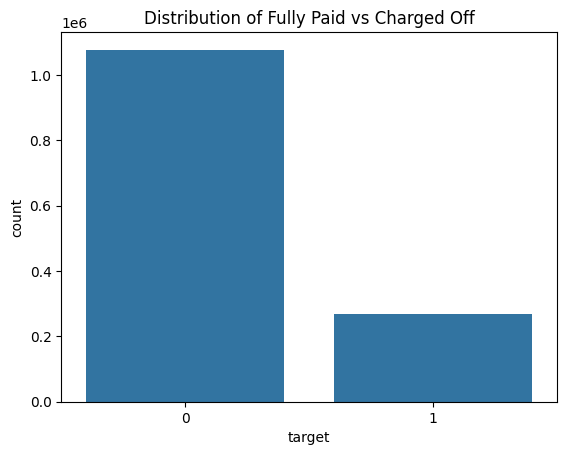

In [17]:
sns.countplot(x=df['target'])
plt.title("Distribution of Fully Paid vs Charged Off")
plt.show()


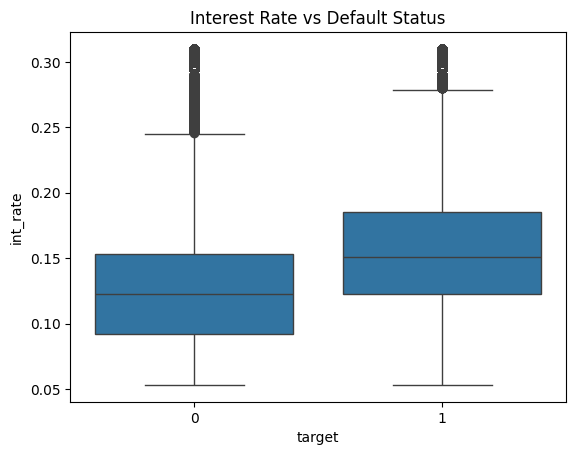

In [18]:
sns.boxplot(data=df, x='target', y='int_rate')
plt.title("Interest Rate vs Default Status")
plt.show()


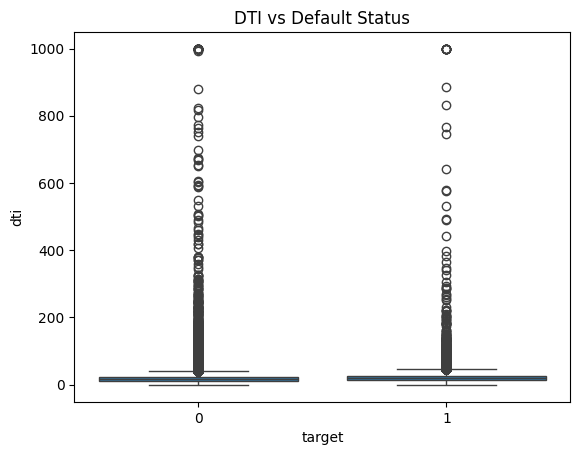

In [19]:
sns.boxplot(data=df, x='target', y='dti')
plt.title("DTI vs Default Status")
plt.show()


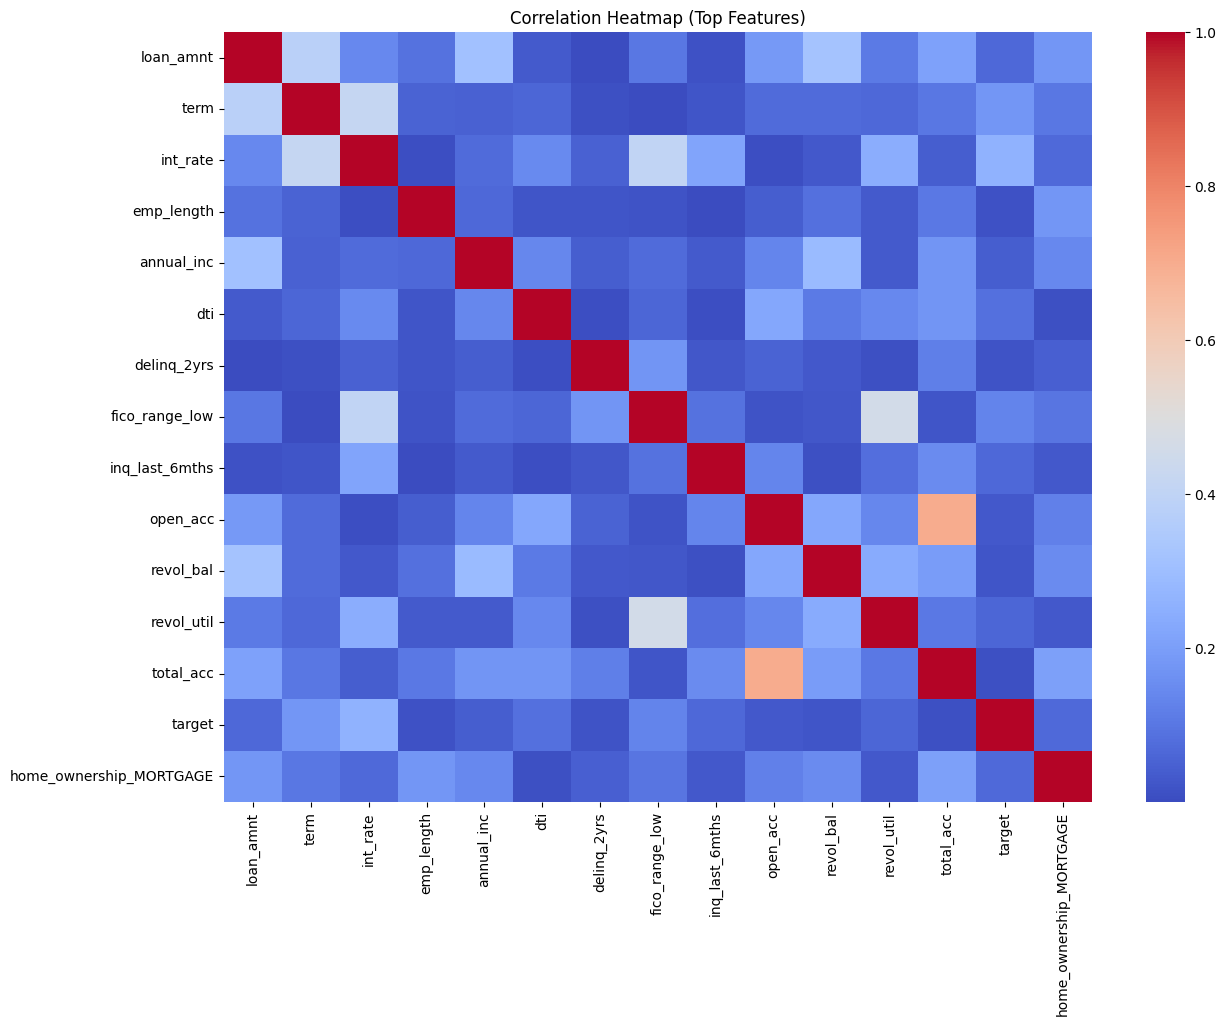

In [20]:
plt.figure(figsize=(14,10))
sns.heatmap(df_encoded.corr().abs().iloc[:15, :15], cmap='coolwarm')
plt.title("Correlation Heatmap (Top Features)")
plt.show()


In [21]:
X = df_encoded.drop(columns=['target']).values.astype(np.float32)
y = df_encoded['target'].values.astype(int)

X.shape, y.shape


((1345310, 84), (1345310,))

In [26]:
import os

SAVE_DIR = os.path.join("..", "data")  # go up one level

os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(X, os.path.join(SAVE_DIR, "X_preprocessed.joblib"))
joblib.dump(y, os.path.join(SAVE_DIR, "y_preprocessed.joblib"))

print("Saved X and y!")

Saved X and y!


In [27]:
joblib.dump(df_encoded, "../data/df_encoded.joblib")

print("Saved df_encoded to ../data/df_encoded.joblib")
print("Shape:", df_encoded.shape)

Saved df_encoded to ../data/df_encoded.joblib
Shape: (1345310, 85)
